# 🎮 Super Mario Advance 2 - Reinforcement Learning

This notebook sets up a reinforcement learning environment to train an AI agent to play Super Mario Advance 2 on a GBA emulator.

## Components:
1. **GBA Emulator**: Using `mgba` Python bindings to run the ROM
2. **Gym Environment**: Custom wrapper for RL compatibility  
3. **RL Agent**: Using Stable Baselines 3 (PPO algorithm)
4. **Training & Evaluation**: Train and watch the agent play

## 1. Install Dependencies

First, install the required packages for GBA emulation and reinforcement learning.

In [1]:
# Install required packages
%pip install gymnasium stable-baselines3 opencv-python numpy matplotlib pillow cffi

Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries

## 3. Create Custom GBA Environment

This environment wraps the mGBA emulator to work with Gymnasium/Stable-Baselines3. 

**Key Features:**
- Captures screen frames from the emulator
- Maps discrete actions to GBA button presses
- Calculates rewards based on Mario's progress (X position) and coins collected
- Handles game state (lives, level completion)

In [2]:
import subprocess
import os
import time
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from PIL import Image
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.callbacks import BaseCallback
import warnings
warnings.filterwarnings('ignore')

# Path to the ROM
ROM_PATH = os.path.abspath("data/Super Mario Advance 2.gba")
print(f"ROM exists: {os.path.exists(ROM_PATH)}")
print(f"ROM path: {ROM_PATH}")

# Find mGBA executable
MGBA_PATH = "/opt/homebrew/Cellar/mgba/0.10.5_1/bin/mGBA"
print(f"mGBA exists: {os.path.exists(MGBA_PATH)}")


class SuperMarioAdvance2Env(gym.Env):
    """
    Custom Gymnasium environment for Super Mario Advance 2 (GBA).
    
    Uses mGBA + macOS Quartz screen capture + AppleScript for keyboard input.
    """
    
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 60}
    
    # GBA screen dimensions
    SCREEN_WIDTH = 240
    SCREEN_HEIGHT = 160
    
    # Observation dimensions
    OBS_WIDTH = 84
    OBS_HEIGHT = 84
    
    # Action definitions
    ACTIONS = {
        0: [],                      # NOOP
        1: ['Right'],               # Move right
        2: ['Right', 'z'],          # Jump right (z = A button)
        3: ['Right', 'x'],          # Run right (x = B button)  
        4: ['Right', 'z', 'x'],     # Run + jump right
        5: ['Left'],                # Move left
        6: ['Left', 'z'],           # Jump left
        7: ['z'],                   # Jump in place
        8: ['Down'],                # Duck
        9: ['x'],                   # Run/spin
    }
    
    def __init__(self, rom_path, render_mode=None, frame_skip=4):
        super().__init__()
        
        self.rom_path = rom_path
        self.render_mode = render_mode
        self.frame_skip = frame_skip
        
        # Action and observation spaces
        self.action_space = spaces.Discrete(len(self.ACTIONS))
        self.observation_space = spaces.Box(
            low=0, high=255,
            shape=(self.OBS_HEIGHT, self.OBS_WIDTH, 1),
            dtype=np.uint8
        )
        
        # Emulator process
        self.emulator_process = None
        self.window_id = None
        
        # State tracking
        self.prev_frame = None
        self.steps = 0
        self.max_steps = 4500
        self.episode_reward = 0
        
        # Check for Quartz
        try:
            import Quartz
            self.quartz_available = True
        except ImportError:
            self.quartz_available = False
            print("⚠️  Quartz not available")
            
    def _start_emulator(self):
        """Start mGBA with the ROM."""
        if self.emulator_process is not None:
            return
            
        print(f"Starting mGBA with ROM: {self.rom_path}")
        
        cmd = [MGBA_PATH, self.rom_path]
        self.emulator_process = subprocess.Popen(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )
        
        time.sleep(3)
        print(f"✅ mGBA started (PID: {self.emulator_process.pid})")
        
        # Bring mGBA to front
        self._bring_to_front()
        time.sleep(0.5)
        
        self._find_window()
        
    def _bring_to_front(self):
        """Bring mGBA window to front."""
        try:
            script = '''
            tell application "mGBA"
                activate
            end tell
            '''
            subprocess.run(['osascript', '-e', script], capture_output=True, timeout=2)
        except:
            pass
        
    def _find_window(self):
        """Find the mGBA window ID for screen capture."""
        if not self.quartz_available:
            return
            
        import Quartz
        
        windows = Quartz.CGWindowListCopyWindowInfo(
            Quartz.kCGWindowListOptionOnScreenOnly,
            Quartz.kCGNullWindowID
        )
        
        for window in windows:
            owner = window.get('kCGWindowOwnerName', '')
            if 'mGBA' in str(owner):
                self.window_id = window.get('kCGWindowNumber')
                return
                
        print("⚠️  Could not find mGBA window")
        
    def _capture_screen(self):
        """Capture the mGBA window using Quartz."""
        if not self.quartz_available or self.window_id is None:
            return np.zeros((self.SCREEN_HEIGHT, self.SCREEN_WIDTH, 3), dtype=np.uint8)
            
        import Quartz
        
        try:
            # Capture the specific window by ID
            image = Quartz.CGWindowListCreateImage(
                Quartz.CGRectNull,
                Quartz.kCGWindowListOptionIncludingWindow,
                self.window_id,
                Quartz.kCGWindowImageBoundsIgnoreFraming
            )
            
            if image is None:
                return self.prev_frame if self.prev_frame is not None else \
                       np.zeros((self.SCREEN_HEIGHT, self.SCREEN_WIDTH, 3), dtype=np.uint8)
            
            # Get image dimensions
            img_width = Quartz.CGImageGetWidth(image)
            img_height = Quartz.CGImageGetHeight(image)
            bytes_per_row = Quartz.CGImageGetBytesPerRow(image)
            
            # Get bitmap data
            data_provider = Quartz.CGImageGetDataProvider(image)
            data = Quartz.CGDataProviderCopyData(data_provider)
            
            # Convert to numpy array
            arr = np.frombuffer(data, dtype=np.uint8)
            
            # Check if data is valid (not all zeros)
            if arr.max() == 0:
                return self.prev_frame if self.prev_frame is not None else \
                       np.zeros((self.SCREEN_HEIGHT, self.SCREEN_WIDTH, 3), dtype=np.uint8)
            
            # Handle bytes_per_row (may include padding due to Retina)
            pixels_per_row = bytes_per_row // 4
            arr = arr.reshape((img_height, pixels_per_row, 4))
            arr = arr[:, :img_width, :]  # Remove any padding
            
            # Convert BGRA to RGB
            frame = cv2.cvtColor(arr, cv2.COLOR_BGRA2RGB)
            
            self.prev_frame = frame
            return frame
            
        except Exception as e:
            print(f"Screen capture error: {e}")
            return self.prev_frame if self.prev_frame is not None else \
                   np.zeros((self.SCREEN_HEIGHT, self.SCREEN_WIDTH, 3), dtype=np.uint8)
    
    def _send_keys(self, keys, press=True):
        """Send keyboard input via AppleScript."""
        if not keys:
            return
            
        key_map = {
            'z': 'z', 'x': 'x',
            'Right': '124', 'Left': '123', 'Up': '126', 'Down': '125',
            'Return': '36',
        }
        
        for key in keys:
            if key in ['Right', 'Left', 'Up', 'Down', 'Return']:
                # Use key code for special keys
                code = key_map.get(key)
                script = f'''
                tell application "System Events"
                    key {"down" if press else "up"} {code}
                end tell
                '''
            else:
                # Use keystroke for regular keys
                script = f'''
                tell application "System Events"
                    keystroke "{key}"
                end tell
                '''
                
            try:
                subprocess.run(['osascript', '-e', script], 
                             capture_output=True, timeout=0.5)
            except:
                pass
                
    def _get_observation(self):
        """Get the current observation."""
        frame = self._capture_screen()
        
        # Resize to GBA resolution (handles Retina 2x scaling)
        frame = cv2.resize(frame, (self.SCREEN_WIDTH, self.SCREEN_HEIGHT))
        
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        
        # Resize to observation size
        resized = cv2.resize(gray, (self.OBS_WIDTH, self.OBS_HEIGHT))
        
        return resized.reshape(self.OBS_HEIGHT, self.OBS_WIDTH, 1).astype(np.uint8)
    
    def _estimate_reward(self, current_frame, prev_frame):
        """Estimate reward using image-based heuristics."""
        if prev_frame is None:
            return 0.0
            
        # Resize both frames to same size for comparison
        curr_small = cv2.resize(current_frame, (self.SCREEN_WIDTH, self.SCREEN_HEIGHT))
        prev_small = cv2.resize(prev_frame, (self.SCREEN_WIDTH, self.SCREEN_HEIGHT))
            
        # Convert to grayscale
        if len(curr_small.shape) == 3:
            curr_gray = cv2.cvtColor(curr_small, cv2.COLOR_RGB2GRAY)
            prev_gray = cv2.cvtColor(prev_small, cv2.COLOR_RGB2GRAY)
        else:
            curr_gray, prev_gray = curr_small, prev_small
            
        # Calculate movement (screen change)
        diff = cv2.absdiff(curr_gray, prev_gray)
        movement = np.mean(diff)
        
        reward = 0.0
        if movement > 5:
            reward += 0.1  # Reward for movement/progress
        if movement < 2:
            reward -= 0.05  # Penalty for standing still
        reward -= 0.01  # Small time penalty
        
        return reward
        
    def step(self, action):
        """Execute one step."""
        self.steps += 1
        
        frame_before = self._capture_screen()
        
        # Execute action
        keys = self.ACTIONS.get(action, [])
        self._send_keys(keys, press=True)
        time.sleep(self.frame_skip / 60.0)
        self._send_keys(keys, press=False)
        time.sleep(0.02)
        
        frame_after = self._capture_screen()
        obs = self._get_observation()
        
        reward = self._estimate_reward(frame_after, frame_before)
        self.episode_reward += reward
        
        terminated = False
        truncated = self.steps >= self.max_steps
        
        info = {'steps': self.steps, 'episode_reward': self.episode_reward}
        
        return obs, reward, terminated, truncated, info
        
    def reset(self, seed=None, options=None):
        """Reset the environment."""
        super().reset(seed=seed)
        
        if self.emulator_process is None:
            self._start_emulator()
        else:
            self._bring_to_front()
            
        # Reset game (Cmd+R in mGBA)
        try:
            script = '''
            tell application "System Events"
                keystroke "r" using command down
            end tell
            '''
            subprocess.run(['osascript', '-e', script], capture_output=True, timeout=1)
        except:
            pass
            
        time.sleep(1)
        
        # Press Start/Enter to advance through menus
        for _ in range(3):
            self._send_keys(['Return'], press=True)
            time.sleep(0.1)
            self._send_keys(['Return'], press=False)
            time.sleep(0.5)
        
        # Reset state
        self.prev_frame = None
        self.steps = 0
        self.episode_reward = 0
        
        self._find_window()
        
        return self._get_observation(), {}
        
    def render(self):
        """Render current frame."""
        frame = self._capture_screen()
        
        if self.render_mode == "human":
            plt.figure(figsize=(8, 5))
            plt.imshow(frame)
            plt.title("Super Mario Advance 2")
            plt.axis('off')
            plt.show()
            
        return frame
        
    def close(self):
        """Clean up."""
        # Release all keys
        for keys in self.ACTIONS.values():
            self._send_keys(keys, press=False)
            
        if self.emulator_process:
            self.emulator_process.terminate()
            self.emulator_process.wait()
            self.emulator_process = None


print("✅ SuperMarioAdvance2Env class defined!")
print()
print("⚠️  Important notes:")
print("- mGBA window must be visible (not minimized)")
print("- Grant Screen Recording permission if needed")
print("- Grant Accessibility permission for keyboard input")

ROM exists: True
ROM path: /Users/informatics/Documents/GitHub/reinforced-super-mario/data/Super Mario Advance 2.gba
mGBA exists: True
✅ SuperMarioAdvance2Env class defined!

⚠️  Important notes:
- mGBA window must be visible (not minimized)
- Grant Screen Recording permission if needed
- Grant Accessibility permission for keyboard input


## 4. Test the Environment

Let's make sure the environment works correctly before training.

Testing environment...
⚠️  mGBA window will open. Keep it visible and don't close it!

Starting mGBA with ROM: /Users/informatics/Documents/GitHub/reinforced-super-mario/data/Super Mario Advance 2.gba
✅ mGBA started (PID: 1650)
✅ Environment initialized!
Observation shape: (84, 84, 1)
Action space: Discrete(10)

Taking 5 test steps...
  Step 1: Action=8, Reward=0.09
  Step 2: Action=9, Reward=0.09
  Step 3: Action=3, Reward=-0.01
  Step 4: Action=4, Reward=-0.06
  Step 5: Action=6, Reward=-0.01


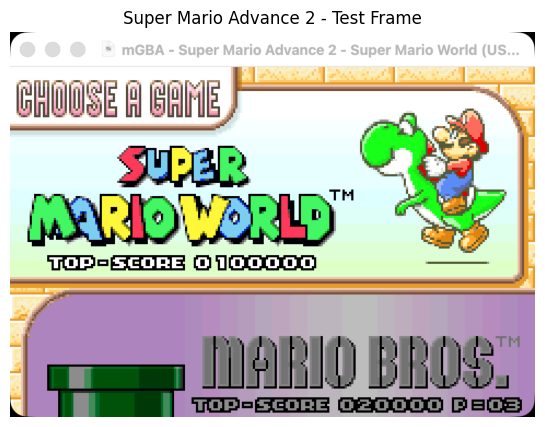


✅ Environment test complete!
Environment closed.


In [3]:
# Test the environment
print("Testing environment...")
print("⚠️  mGBA window will open. Keep it visible and don't close it!")
print()

# Create environment
env = SuperMarioAdvance2Env(ROM_PATH)
obs, info = env.reset()

print(f"✅ Environment initialized!")
print(f"Observation shape: {obs.shape}")
print(f"Action space: {env.action_space}")
print()

# Take a few steps
print("Taking 5 test steps...")
for i in range(5):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"  Step {i+1}: Action={action}, Reward={reward:.2f}")

# Display the current frame
frame = env.render()
plt.figure(figsize=(8, 5))
plt.imshow(frame)
plt.title("Super Mario Advance 2 - Test Frame")
plt.axis('off')
plt.show()

print()
print("✅ Environment test complete!")

# Close environment
env.close()
print("Environment closed.")

## 5. Training Callback

Custom callback to track training progress and save best models.

In [4]:
class TrainingCallback(BaseCallback):
    """
    Custom callback for tracking training progress.
    """
    def __init__(self, check_freq=10000, save_path='./models/', verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        self.best_mean_reward = -np.inf
        self.episode_rewards = []
        self.episode_lengths = []
        
        os.makedirs(save_path, exist_ok=True)
        
    def _on_step(self):
        # Log info periodically
        if self.n_calls % self.check_freq == 0:
            # Get episode statistics from the environment
            if len(self.model.ep_info_buffer) > 0:
                mean_reward = np.mean([ep['r'] for ep in self.model.ep_info_buffer])
                mean_length = np.mean([ep['l'] for ep in self.model.ep_info_buffer])
                
                if self.verbose:
                    print(f"Step {self.n_calls}")
                    print(f"  Mean reward: {mean_reward:.2f}")
                    print(f"  Mean episode length: {mean_length:.0f}")
                
                # Save best model
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    self.model.save(f"{self.save_path}/best_model")
                    if self.verbose:
                        print(f"  🏆 New best model saved!")
        
        return True
    
    def _on_training_end(self):
        # Save final model
        self.model.save(f"{self.save_path}/final_model")
        print(f"✅ Training complete! Final model saved.")

print("✅ TrainingCallback defined!")

✅ TrainingCallback defined!


## 6. Create and Train the Agent

Using PPO (Proximal Policy Optimization) - a robust RL algorithm that works well with image-based observations.

**Training Tips:**
- Training will take a long time (hours to days) for good results
- Start with a smaller `total_timesteps` to test, then increase
- Use GPU if available for faster training
- The memory addresses may need fine-tuning for accurate rewards

In [5]:
def make_env():
    """Factory function to create the environment."""
    env = SuperMarioAdvance2Env(ROM_PATH, render_mode="rgb_array")
    return env

# Create vectorized environment with frame stacking
# Frame stacking helps the agent understand motion/velocity
env = DummyVecEnv([make_env])
env = VecFrameStack(env, n_stack=4)

print(f"Environment created!")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

Environment created!
Observation space: Box(0, 255, (84, 84, 4), uint8)
Action space: Discrete(10)


In [6]:
# Create the PPO agent
# Using CNN policy for image observations
model = PPO(
    "CnnPolicy",
    env,
    verbose=1,
    learning_rate=2.5e-4,
    n_steps=128,
    batch_size=32,
    n_epochs=4,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    tensorboard_log=None  # Disable tensorboard for now (restart kernel to use it)
)

print("✅ PPO Agent created!")
print(f"Policy: {model.policy}")

Using cpu device
Wrapping the env in a VecTransposeImage.
✅ PPO Agent created!
Policy: ActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, b

In [7]:
# Train the agent
# Start with fewer steps to test, then increase for better results
# Recommended: 1_000_000+ steps for good performance

TOTAL_TIMESTEPS = 5_000  # Start small to test, increase to 100K-1M+ for real training

callback = TrainingCallback(check_freq=1000, save_path='./models/')

print("🎮 Starting training...")
print(f"Total timesteps: {TOTAL_TIMESTEPS:,}")
print("⚠️  Keep the mGBA window visible and don't interact with it!")
print("Training progress will be logged periodically.\n")

model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=callback,
    progress_bar=False  # Disable progress bar (requires tqdm/rich)
)

print("\n✅ Training complete!")

🎮 Starting training...
Total timesteps: 5,000
⚠️  Keep the mGBA window visible and don't interact with it!
Training progress will be logged periodically.

Starting mGBA with ROM: /Users/informatics/Documents/GitHub/reinforced-super-mario/data/Super Mario Advance 2.gba
✅ mGBA started (PID: 1758)
----------------------------
| time/              |     |
|    fps             | 1   |
|    iterations      | 1   |
|    time_elapsed    | 84  |
|    total_timesteps | 128 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1           |
|    iterations           | 2           |
|    time_elapsed         | 168         |
|    total_timesteps      | 256         |
| train/                  |             |
|    approx_kl            | 0.004158128 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.3        |
|    explained_variance   | -0.34      

## 7. Evaluate and Watch the Agent Play

After training, let's see how well the agent performs!

In [ ]:
# Load the best model (or use the trained model directly)
try:
    best_model = PPO.load("./models/best_model", env=env)
    print("✅ Loaded best model from training")
except:
    best_model = model
    print("Using current model (no saved best model found)")

def evaluate_agent(model, env, num_episodes=5):
    """Evaluate the agent over multiple episodes."""
    episode_rewards = []
    episode_lengths = []
    
    for episode in range(num_episodes):
        obs = env.reset()
        total_reward = 0
        steps = 0
        done = False
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            total_reward += reward[0]
            steps += 1
            
            if done[0]:
                break
        
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        print(f"Episode {episode + 1}: Reward = {total_reward:.2f}, Steps = {steps}")
    
    print(f"\n📊 Average Reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
    print(f"📊 Average Steps: {np.mean(episode_lengths):.0f} ± {np.std(episode_lengths):.0f}")
    
    return episode_rewards, episode_lengths

# Evaluate the trained agent
print("🎮 Evaluating agent performance...\n")
rewards, lengths = evaluate_agent(best_model, env, num_episodes=3)

Using current model (no saved best model found)
🎮 Evaluating agent performance...



In [ ]:
from IPython.display import HTML
from matplotlib import animation

def record_gameplay(model, env, max_frames=500):
    """Record a gameplay video."""
    frames = []
    obs = env.reset()
    
    # Get underlying environment for rendering
    base_env = env.envs[0]
    
    for _ in range(max_frames):
        # Render frame
        frame = base_env.render()
        frames.append(frame)
        
        # Get action from model
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        
        if done[0]:
            break
    
    return frames

def create_animation(frames, fps=30):
    """Create an animation from frames."""
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.axis('off')
    
    img = ax.imshow(frames[0])
    
    def animate(i):
        img.set_array(frames[i])
        return [img]
    
    anim = animation.FuncAnimation(
        fig, animate, frames=len(frames),
        interval=1000/fps, blit=True
    )
    
    plt.close()
    return anim

# Record gameplay
print("🎬 Recording gameplay...")
frames = record_gameplay(best_model, env, max_frames=300)
print(f"Recorded {len(frames)} frames")

# Create and display animation
anim = create_animation(frames, fps=30)
HTML(anim.to_jshtml())

## 8. Save/Load Models

Save your trained model to continue training later or share it.

In [8]:
# Save the final trained model
model.save("./models/super_mario_ppo_final")
print("✅ Model saved to ./models/super_mario_ppo_final.zip")

# To load a saved model later:
# loaded_model = PPO.load("./models/super_mario_ppo_final", env=env)

# To continue training from a saved model:
# loaded_model.learn(total_timesteps=100000, reset_num_timesteps=False)

✅ Model saved to ./models/super_mario_ppo_final.zip


## 9. Advanced: Memory Address Discovery (Optional)

The reward function relies on reading memory addresses from the GBA. If the default addresses don't work correctly, you can use this cell to search for the correct memory addresses by watching values change as you play.

In [ ]:
def scan_memory_for_value(core, target_value, memory_range=(0x02000000, 0x02040000)):
    """
    Scan memory to find addresses containing a specific value.
    Useful for finding memory addresses for coins, lives, position, etc.
    
    Args:
        core: mGBA core instance
        target_value: The value to search for (e.g., current coin count)
        memory_range: Tuple of (start_address, end_address) to search
    
    Returns:
        List of addresses containing the target value
    """
    matches = []
    start, end = memory_range
    
    for addr in range(start, end):
        try:
            value = core.memory.u8[addr]
            if value == target_value:
                matches.append(hex(addr))
        except:
            pass
    
    return matches

# Example usage - uncomment to use:
# test_env = SuperMarioAdvance2Env(ROM_PATH)
# test_env.reset()
# 
# # Play a bit to get some coins (e.g., 5 coins)
# for _ in range(100):
#     test_env.step(1)  # Move right
# 
# # Search for the coin count in memory
# # Replace '5' with your actual coin count shown on screen
# matches = scan_memory_for_value(test_env.core, 5)
# print(f"Found {len(matches)} addresses with value 5: {matches[:20]}...")
# 
# test_env.close()

print("Memory scanning function defined. Uncomment the code above to search for memory addresses.")

## 10. Cleanup

In [ ]:
# Clean up environment
env.close()
print("✅ Environment closed. Training session complete!")

---

## 📝 Notes & Tips for Success

### Training Recommendations:
1. **Start small**: Begin with 100K timesteps to verify everything works, then scale up to 1M+ for better results
2. **GPU acceleration**: Training is faster with a GPU. Install `torch` with CUDA support if available
3. **Patience**: RL for games typically needs millions of steps to become proficient

### Tuning the Reward Function:
The reward function is crucial for learning. You may need to adjust:
- **Memory addresses**: The default addresses are estimates. Use the memory scanner to find accurate addresses for your ROM
- **Reward scaling**: Adjust the reward multipliers based on observed behavior
- **Additional signals**: Consider adding rewards for power-ups, time bonuses, or level completion

### Common Issues:
- **Game not starting**: The reset sequence may need adjustment for different ROMs
- **Agent not learning**: Try different hyperparameters or reward shaping
- **Memory errors**: GBA memory addresses vary between ROM versions

### Alternative Approaches:
- **Retro library**: `gym-retro` supports many games but not GBA natively
- **Different algorithms**: Try A2C, DQN, or SAC instead of PPO
- **Imitation learning**: Train on human demonstrations first, then fine-tune with RL